# Look at it (left vs. right induced subgraphs)

## Preliminaries

In [1]:
from pkg.utils import set_warnings

import datetime
import time

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from graspologic.embed import selectSVD
from sklearn.preprocessing import normalize
from graspologic.utils import pass_to_ranks
from umap import AlignedUMAP
from giskard.plot import graphplot
from src.visualization import CLASS_COLOR_DICT

from graspologic.align import OrthogonalProcrustes, SeedlessProcrustes
from graspologic.embed import (
    AdjacencySpectralEmbed,
    OmnibusEmbed,
    select_dimension,
)
from graspologic.match import GraphMatch
from graspologic.plot import pairplot
from graspologic.utils import (
    augment_diagonal,
    binarize,
    multigraph_lcc_intersection,
    pass_to_ranks,
)
from pkg.data import (
    load_maggot_graph,
    load_palette,
    select_nice_nodes,
    load_node_palette,
    load_network_palette,
)
from pkg.io import savefig
from pkg.plot import set_theme
from giskard.utils import get_paired_inds

from src.visualization import adjplot  # TODO fix graspologic version and replace here


def stashfig(name, **kwargs):
    foldername = "look_at_it"
    savefig(name, foldername=foldername, **kwargs)

## Load and process data

In [2]:

t0 = time.time()
set_theme()

network_palette, NETWORK_KEY = load_network_palette()
node_palette, NODE_KEY = load_node_palette()

mg = load_maggot_graph()
mg = select_nice_nodes(mg)
nodes = mg.nodes
left_nodes = nodes[nodes["hemisphere"] == "L"]
left_inds = left_nodes["_inds"]
right_nodes = nodes[nodes["hemisphere"] == "R"]
right_inds = right_nodes["_inds"]
left_paired_inds, right_paired_inds = get_paired_inds(
    nodes, pair_key="predicted_pair", pair_id_key="predicted_pair_id"
)
right_paired_inds_shifted = right_paired_inds - len(left_inds)
adj = mg.sum.adj
ll_adj = adj[np.ix_(left_inds, left_inds)]
rr_adj = adj[np.ix_(right_inds, right_inds)]

Removed 13 nodes when taking the largest connected component.
Removed 38 nodes when removing pendants.
Removed 0 nodes when taking the largest connected component.


## Plot the ipsilateral subgraph adjacency matrices

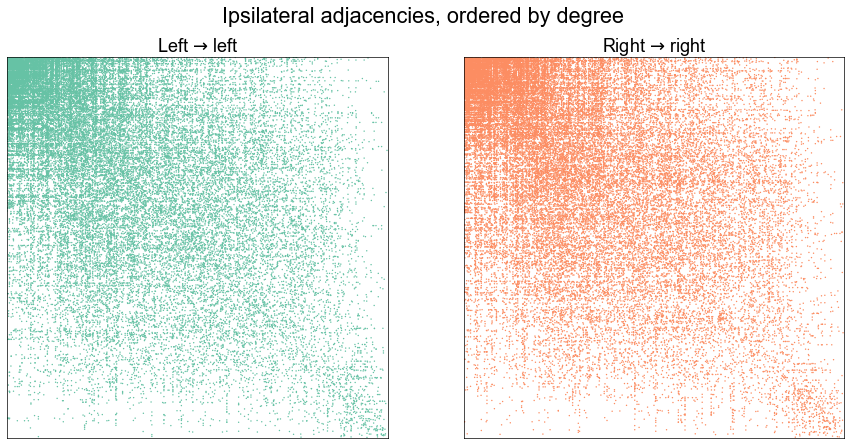

In [3]:


def calculate_weighted_degrees(adj):
    return np.sum(adj, axis=0) + np.sum(adj, axis=1)


def plot_adjs(left, right, title=""):

    fig, axs = plt.subplots(1, 2, figsize=(15, 7))
    adjplot(
        left,
        item_order=-calculate_weighted_degrees(left),
        plot_type="scattermap",
        sizes=(2, 2),
        ax=axs[0],
        title=r"Left $\to$ left",
        color=network_palette["Left"],
    )
    adjplot(
        right,
        item_order=-calculate_weighted_degrees(right),
        plot_type="scattermap",
        sizes=(2, 2),
        ax=axs[1],
        title=r"Right $\to$ right",
        color=network_palette["Right"],
    )
    fig.suptitle(title, ha="center", x=0.51)
    return fig, axs


plot_adjs(ll_adj, rr_adj, title="Ipsilateral adjacencies, ordered by degree")
stashfig("ipsilateral-adj-degree")

In [4]:


def ase(adj, n_components=None):
    U, S, Vt = selectSVD(adj, n_components=n_components, algorithm="full")
    S_sqrt = np.diag(np.sqrt(S))
    X = U @ S_sqrt
    Y = Vt.T @ S_sqrt
    return X, Y


def prescale_for_embed(adjs):
    norms = [np.linalg.norm(adj, ord="fro") for adj in adjs]
    mean_norm = np.mean(norms)
    adjs = [adjs[i] * mean_norm / norms[i] for i in range(len(adjs))]
    return adjs

## Plot a graph layout for each hemisphere

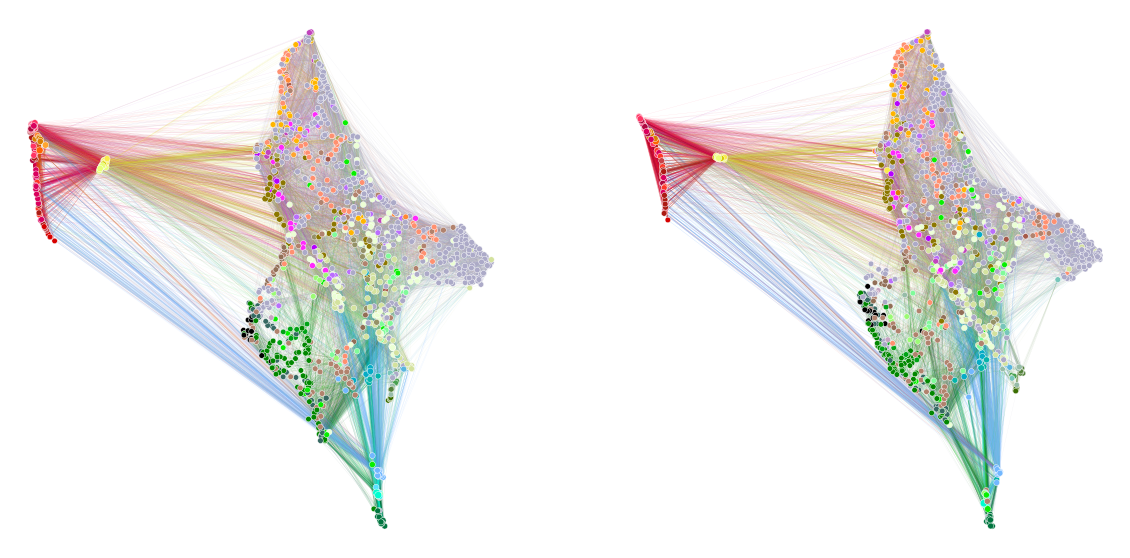

In [5]:
n_components = 16  # 24 looked fine
power = True
normed = False
if power:
    ll_adj_for_umap = pass_to_ranks(ll_adj)
    rr_adj_for_umap = pass_to_ranks(rr_adj)
    if normed:
        ll_adj_for_umap = normalize(ll_adj_for_umap, axis=1)
        rr_adj_for_umap = normalize(rr_adj_for_umap, axis=1)
    ll_adj_for_umap = ll_adj_for_umap @ ll_adj_for_umap
    rr_adj_for_umap = rr_adj_for_umap @ rr_adj_for_umap
else:
    ll_adj_for_umap = pass_to_ranks(ll_adj)
    rr_adj_for_umap = pass_to_ranks(rr_adj)

X_ll, Y_ll = ase(ll_adj_for_umap, n_components=n_components)
X_rr, Y_rr = ase(rr_adj_for_umap, n_components=n_components)

Z_ll = np.concatenate((X_ll, Y_ll), axis=1)
Z_rr = np.concatenate((X_rr, Y_rr), axis=1)
# Z_ll, _ = ase(Z_ll, n_components=n_components)
# Z_rr, _ = ase(Z_rr, n_components=n_components)

relation_dict = dict(zip(left_paired_inds, right_paired_inds_shifted))

aumap = AlignedUMAP(
    random_state=88888,
    n_neighbors=32,
    min_dist=0.95,
    metric="cosine",
    alignment_regularisation=1e-2,
)
umap_embeds = aumap.fit_transform([Z_ll, Z_rr], relations=[relation_dict])

graphplot_kws = dict(sizes=(30, 60))
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
graphplot(
    network=ll_adj,
    embedding=umap_embeds[0],
    meta=left_nodes,
    hue="merge_class",
    palette=CLASS_COLOR_DICT,
    ax=axs[0],
    **graphplot_kws,
)
graphplot(
    network=rr_adj,
    embedding=umap_embeds[1],
    meta=right_nodes,
    hue="merge_class",
    palette=CLASS_COLOR_DICT,
    ax=axs[1],
    **graphplot_kws,
)
stashfig("aligned-umap-layout")

## Simple statistics for the left hemisphere induced subgraph

In [6]:
ll_mg, rr_mg, _, _ = mg.bisect(paired=False)
ll_mg.sum

,n_nodes,n_edges,sum_edge_weights
edge_type,,,
sum,1481.0,36447.0,117068.0


## Simple statistics for the right hemisphere induced subgraph

In [7]:
rr_mg.sum

,n_nodes,n_edges,sum_edge_weights
edge_type,,,
sum,1481.0,39096.0,129527.0


In [8]:
elapsed = time.time() - t0
delta = datetime.timedelta(seconds=elapsed)
print("----")
print(f"Script took {delta}")
print(f"Completed at {datetime.datetime.now()}")
print("----")

----
Script took 0:01:21.321180
Completed at 2021-05-10 18:23:09.329480
----
